# Link Prediction on LastFM music dataset- Pytorch Geometric (Not my Master thesis!)

This Jupyter notebook demonstrates **link prediction** using **Graph Neural Networks (GNNs)** on the **LastFM** dataset with **PyTorch Geometric**. The task is to **predict potential links between users and artists in a heterogeneous bipartite graph**, where the **nodes represent users and artists**, and the **edges represent user interactions with artists**. By applying GNN-based techniques, we aim to predict missing or future edges between users and artists, utilizing the graph's structure and node features to enhance the accuracy of the predictions.

This is **not my Master thesis**. It was just a short example that I worked on to understand the fundamentals of how GNNs can be used to approach the problem of Link prediction. **The Master Thesis invovles more thorough research and experimentation based on recent research papers and on a real-life dataset from the city of Brønderslev, Denmark**

### Fictional use case description

A graph is created with two types of nodes: users and artists. 
- Every user of the streaming platform has a node for themselves in the graph. So do the artists.
- The dataset is weird in the way that it has more artists than users which is often not how one would expect the dataset to be like.
- When a user follows an artist on the streaming platform, an edge is created in the graph between the user and the artist.

**Goal: The goal is to predict the existence of links between users and artists. When using GNNs, the underlying model learns from the structure of the graphs (from the existing connections) and becomes capable of prediction the links based on the patterns learned. So when a user visits an artist's page on the streaming platform, a score can be displayed which indicates how likely it is that the user might like this artist.** 

### Dataset introduction: LastFM

**Source to import from**: From torch_geometric.datasets

**Data Description**: 
- A subset of the last.fm music website keeping track of users’ listining information from various sources, as collected in the “MAGNN: Metapath Aggregated Graph Neural Network for Heterogeneous Graph Embedding” paper. 
- last.fm is a heterogeneous graph containing three types of entities - users (1,892 nodes), artists (17,632 nodes), and artist tags (1,088 nodes). 
- This dataset can be used for link prediction, and no labels or features are provided.

Task relevant details are discussed below as needed in the section that follow.

### 1. Import all the libraries

To train a model to perform link prediction, pytorch and pytorch geometric are used. All relevant components are imported below. In addition, Matplotlib is used to plot the loss curves. 

In [1]:
import torch
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn.functional as F


from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.nn import ModuleList, Linear
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import LastFM
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero

### 2. Define the parameters for training

The code relies on defining certain parameter values that are used in the following sections.

- val_ratio (Validation ratio): Indicates how much of the data needs to be in the validation split.
- test_ratio (Test ratio): Indicates how much of the data needs to be in the test split.
- neg_sampling_ratio (Negative sampling ratio): Indicates how many negative edges need to be sampled.
- num_neighbors (Number of neighbors): Inidicates how many neighboring nodes are considered when sampling subgraphs
- num_hops (Number of hops): Indicates how many hops are considered when sampling subgraphs
- hidden_channels (Hidden channels): Indicates the number of channels to use in the intermediate GNN layers.
- num_layers (Number of layers): Indicates the number of layers the GNN model is trained on.
- lr (Learning rate): Indicates the learning rate used to train the GNN model.
- epochs (Epochs): Indicates the number of epochs for which the model is trained.

In [2]:
args = dict()
args["val_ratio"] = 0.1
args["test_ratio"] = 0.1
args["neg_sampling_ratio"] = 1.0
args["num_neighbors"] = 10
args["num_hops"] = 3
args["hidden_channels"] = 10
args["num_layers"] = 3
args["lr"] = 0.0001
args["epochs"] = 10

#### 3. Loading the dataset

The dataset is loaded by creating an instance of the LastFM class from torch_geometric.datasets

In [3]:
dataset = LastFM(root="../dataset")
print(f"Number of graphs: {len(dataset)}")

Number of graphs: 1


In [4]:
data = dataset[0]
data

HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984],
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)

The dataset contains one heterogeneous graph (HeteroData() object). The graph contains:
- 1892 user nodes
- 17632 artist nodes
- 1088 tag nodes
- edges between users: could mean that the users follow each other.
- edges between artists and users: could mean that the artists are followed by these users
- edges between artists and tags: artists and their relevant tags
- edges between tags and artists: artists and their relevant tags (reverse edges) 
- edges between users and artists: could mean that users follow the artists

There are also additional postive and negatives edges for validation and testing for users to artist edges.

**The link prediction task in this notebook only considers the edges between the users and artists.**

#### 4. Creating the right dataset object

- A **new HeteroData() object is created** that borrows the relevant data from the imported dataset. 

##### Tags
- The edge types that includes tags and the tag nodes are irrelevant to this use case, so they are ignored. 

##### Users and Artists
- These nodes are included. 
- The edges (user, to, artist) are considered, but all the positive edges are combined (edge_index, val_pos_edge_index, test_pos_edge_index).
- The negative edges are ignored (train_neg_edge_index, val_neg_edge_index, test_neg_edge_index). These will be sampled later using Pytorch geometric components.
- The training, validation and testing splits will be performed later. 
- (user, to, user) edges are included.
- (artist, to, user) edges are just reverse edges. These are ignored now as when we convert the new data object to undirected, these edges will automatically be included along with the other edges.

In [11]:
data_new = HeteroData()
data_new["user"].node_id = torch.arange(data["user"].num_nodes)
data_new["artist"].node_id = torch.arange(data["artist"].num_nodes)
data_new["user", "to", "artist"].edge_index = torch.cat((data["user", "to", "artist"].edge_index, data["user", "to", "artist"].val_pos_edge_index, data["user", "to", "artist"].test_pos_edge_index), dim=1)
data_new["user", "to", "user"].edge_index = data["user", "to", "user"].edge_index
data_new = T.ToUndirected()(data_new)
data_new

HeteroData(
  user={ node_id=[1892] },
  artist={ node_id=[17632] },
  (user, to, artist)={ edge_index=[2, 92834] },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, rev_to, user)={ edge_index=[2, 92834] }
)

#### 5. Training, Validation and Testing splits 

The RandomLinkSplit transform from PYG splits the set of links into train, validation and test splits. 

Each split will contains all the nodes and all the reverse edges.

##### Train Split
- **edge_index**: contains 80% of the links as the edge index. **These edges form the graph dataset that is used for training. This is separate from the links that are used for predictions in the training set**
- **edge_label_index**: **Links that are used for predictions.** Contains 80% of the links (coincidentally same as edge_index for training set, but this is not the case for the valid and test sets.) + an equal number of sampled negative edges. 
- **edge_label**: labels for all the links in edge_label_index. 0 for negative edges and 1 for positive edges.

##### Validation Split
- **edge_index**: **same as the training set's edge_index**, because the underlying graph dataset should be the same (as is the case in traditional ML datasets) 
- **edge_label_index**: **Links that are used for predictions.** Contains 10% of the links + an equal number of sampled negative edges. 
- **edge_label**: labels for all the links in edge_label_index. 0 for negative edges and 1 for positive edges.

#### Testing Split
- **edge_index**: train set edge_index + validation set edge_index
- **edge_label_index**: **Links that are used for predictions.** Contains 10% of the links + an equal number of sampled negative edges. 
- **edge_label**: labels for all the links in edge_label_index. 0 for negative edges and 1 for positive edges.


In [12]:
split_transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=True,
    edge_types=("user", "to", "artist"),
    rev_edge_types=("artist", "rev_to", "user"),
)

In [13]:
train_dataset, val_dataset, test_dataset = split_transform(data_new)
train_dataset, val_dataset, test_dataset

(HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 74268],
     edge_label=[148536],
     edge_label_index=[2, 148536],
   },
   (user, to, user)={ edge_index=[2, 25434] },
   (artist, rev_to, user)={ edge_index=[2, 74268] }
 ),
 HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 74268],
     edge_label=[18566],
     edge_label_index=[2, 18566],
   },
   (user, to, user)={ edge_index=[2, 25434] },
   (artist, rev_to, user)={ edge_index=[2, 74268] }
 ),
 HeteroData(
   user={ node_id=[1892] },
   artist={ node_id=[17632] },
   (user, to, artist)={
     edge_index=[2, 83551],
     edge_label=[18566],
     edge_label_index=[2, 18566],
   },
   (user, to, user)={ edge_index=[2, 25434] },
   (artist, rev_to, user)={ edge_index=[2, 83551] }
 ))

#### 6. Batching the data

The LinkNeighborLoader is similar to the DataLoader class from torch. It can be used to batch the samples (links) from the dataset.

For every link, LinkNeighborLoader extracts a subgraph around that link. A simple example of how the subgraph is extracted can be seen in the image below. All the nodes attached to the target nodes (the nodes connected by the sample link) are extracted along with the relevant edges.

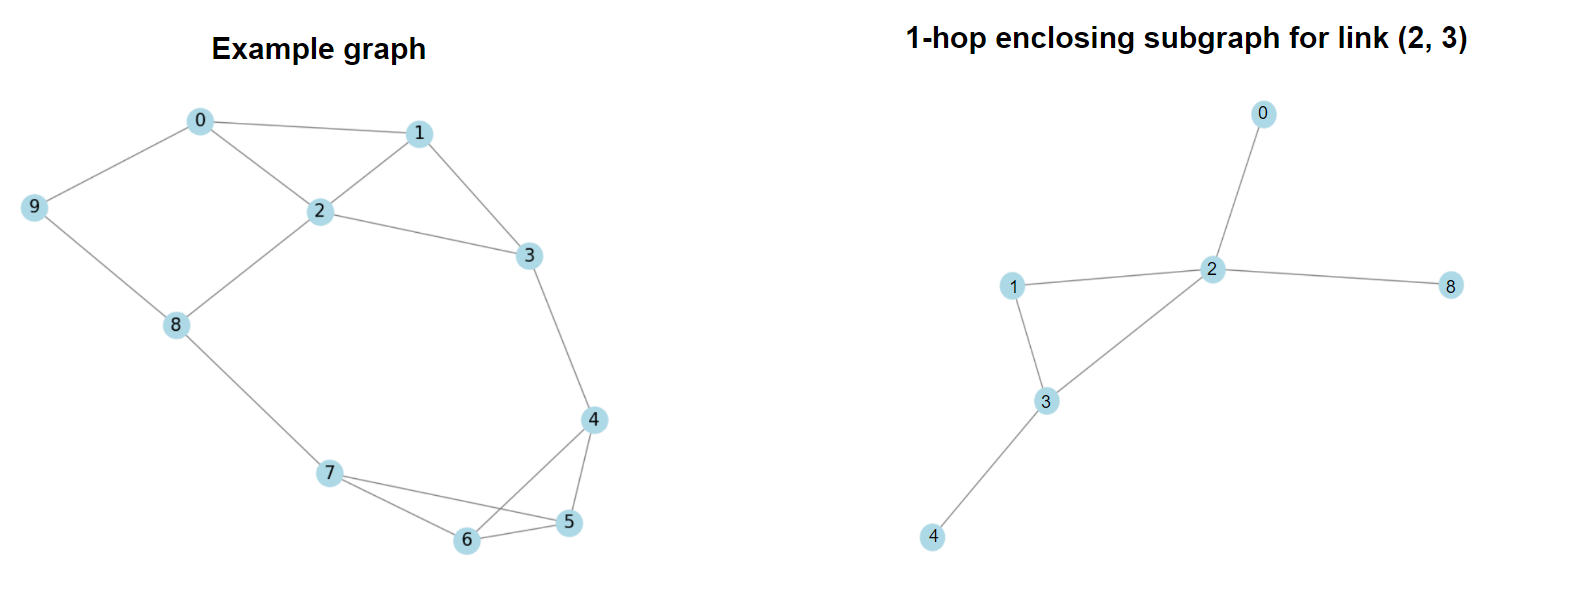

When batch size is 32, the subgraphs around 32 links are extracted and all the nodes and edges are combined to form a single, collective HeteroData() object. 

In [14]:
num_neighbors = [args["num_neighbors"]] * args["num_hops"]

train_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), train_dataset["user", "to", "artist"].edge_label_index),
    edge_label=train_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), val_dataset["user", "to", "artist"].edge_label_index),
    edge_label=val_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

test_loader = LinkNeighborLoader(
    data=data_new,
    num_neighbors=num_neighbors,
    edge_label_index=(("user", "to", "artist"), test_dataset["user", "to", "artist"].edge_label_index),
    edge_label=test_dataset["user", "to", "artist"].edge_label,
    subgraph_type="bidirectional",
    neg_sampling=None,
    batch_size=32,
    shuffle=True
)

In [15]:
sample = next(iter(train_loader))
sample

HeteroData(
  user={
    node_id=[1887],
    n_id=[1887],
  },
  artist={
    node_id=[5521],
    n_id=[5521],
  },
  (user, to, artist)={
    edge_index=[2, 25013],
    input_id=[32],
    edge_label_index=[2, 32],
    edge_label=[32],
  },
  (user, to, user)={ edge_index=[2, 15948] },
  (artist, rev_to, user)={ edge_index=[2, 25013] }
)

The HeteroData sample above combines 32 enclosing subgraphs in a single collective object.

#### 7. Define node embeddings

The dataset that we have here does not have node features (ie, details like user age, artist age, music genre preferences). The graph structure and its connectivity, however, can be useful for a link predicition task like this. With node embeddings, the goal is to capture the structure of graph and convert this representation into vectors so the GNN model can benefit from this. We define two torch Embedding layers, which are trained along with the GNN model. These node embedding act as node features for the GNN model.

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
metadata = sample.metadata()

node_embedding = dict() 
node_embedding["user"] = torch.nn.Embedding(data_new["user"].num_nodes, args["hidden_channels"]).to(device)
node_embedding["artist"] = torch.nn.Embedding(data_new["artist"].num_nodes, args["hidden_channels"]).to(device)

#### 8. Define the GNN model

The GNN model is inspired from the GraphSAGE model. It has been adapted to work with the heterogeneous graph structure that we have in this use case. We start by defining a homogeneous model (GNN_model). We define a second class (Model) that defines:

- the input dimensions
- converts the homogeneous model to a heterogeneous model with the help of the to_hetero() transform from pytorch geometric
- defines the linear layers to be used after the GNN model, needed for the final prediction.

In [17]:
class Model(torch.nn.Module):
    def __init__(self, args, node_embedding, device, metadata, dropout = 0.5):
        super().__init__()

        self.lin1 = Linear(args["hidden_channels"], args["hidden_channels"])
        self.lin2 = Linear(args["hidden_channels"], 1)
        self.dropout = dropout
        self.device = device

        self.node_embedding = node_embedding
        
        initial_channels = 0 

        if self.node_embedding is not None:
            initial_channels += self.node_embedding["user"].embedding_dim    
        
        else:
            initial_channels = args["hidden_channels"]

        self.gnn = GNN_Model(initial_channels, args['hidden_channels'], args['num_layers'], dropout=self.dropout).to(device)
        
        self.gnn = to_hetero(self.gnn, metadata=metadata)
        

    def forward(self, data):
        x_dict = dict()

        if self.node_embedding is not None and self.node_embedding["user"] is not None and self.node_embedding["artist"] is not None and data["user"]["node_id"] is not None and data["artist"]["node_id"] is not None:
            u_emb = self.node_embedding["user"](data["user"]["node_id"])
            a_emb = self.node_embedding["artist"](data["artist"]["node_id"])
            x_dict["user"] = u_emb.to(torch.float)
            x_dict["artist"] = a_emb.to(torch.float)

        x_dict = self.gnn(x=x_dict, edge_index=data.edge_index_dict)
        user = x_dict["user"][data["user", "to", "artist"].edge_label_index[0]]
        artist = x_dict["artist"][data["user", "to", "artist"].edge_label_index[1]]
        
        x = user * artist
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x


class GNN_Model(torch.nn.Module):
    def __init__(self, initial_channels, hidden_channels, num_layers, dropout):
        super(GNN_Model, self).__init__()
        
        self.convs = ModuleList()
        self.convs.append(SAGEConv(initial_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        return x

#### 9. Training the GNN model

The training, testing and validation functions and loops are defined as follows:

In [18]:
def train():
    model.train()

    total_loss = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch)
        loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_dataset)


@torch.no_grad()
def validate_and_test():
    model.eval()
    
    total_val_loss = 0
    y_pred, y_true = [], []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        logits = model(batch)
        val_loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        total_val_loss += val_loss.item()
        y_pred.append(logits.view(-1).cpu())
        y_true.append(batch["user", "to", "artist"].edge_label.view(-1).cpu().to(torch.float))
    val_pred, val_true = torch.cat(y_pred), torch.cat(y_true)

    total_test_loss = 0
    y_pred, y_true = [], []
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        logits = model(batch)
        test_loss = BCEWithLogitsLoss()(logits.view(-1), batch["user", "to", "artist"].edge_label.to(torch.float))
        total_test_loss += test_loss.item()
        y_pred.append(logits.view(-1).cpu())
        y_true.append(batch["user", "to", "artist"].edge_label.view(-1).cpu().to(torch.float))
    test_pred, test_true = torch.cat(y_pred), torch.cat(y_true)


    valid_auc = roc_auc_score(val_true, val_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    results = {}
    results['AUC'] = (valid_auc, test_auc)

    return total_val_loss / len(val_dataset), total_test_loss / len(test_dataset), results

Let's instantiate the model, indicate that the node embeddings need to be trained as well, and define the optimizer. The weights of the embeddings are initialized and the are added to the list of trainable parameters. The list is then passed to the optimizer.  

In [19]:
model = Model(args, node_embedding, device, metadata).to(device)

torch.nn.init.xavier_uniform_(node_embedding["user"].weight)
torch.nn.init.xavier_uniform_(node_embedding["artist"].weight)

parameters = list(node_embedding["user"].parameters())
parameters += list(node_embedding["artist"].parameters())

optimizer = torch.optim.Adam(params=parameters + list(model.parameters()), lr=args['lr'])

g:\miniconda\envs\thesis_seal\Lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
g:\miniconda\envs\thesis_seal\Lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


In [20]:
train_loss_history = []
val_loss_history = []
test_loss_history = []

for epoch in range(args["epochs"]):
    train_loss = train()
    train_loss_history.append(train_loss)

    val_loss, test_loss, results = validate_and_test()
    val_loss_history.append(val_loss)
    test_loss_history.append(test_loss)

    valid_auc, test_auc = results["AUC"]

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation AUC: {valid_auc}")
    print(f"Test Loss: {test_loss:.4f}, Test AUC: {test_auc}")

100%|██████████| 581/581 [00:59<00:00,  9.78it/s]


Epoch: 0
Train Loss: 764.2704
Validation Loss: 82.8667, Validation AUC: 0.7904458902953995
Test Loss: 83.6864, Test AUC: 0.7798206778838127


100%|██████████| 581/581 [00:48<00:00, 12.05it/s]


Epoch: 1
Train Loss: 661.4186
Validation Loss: 73.9005, Validation AUC: 0.8313459745423013
Test Loss: 73.8460, Test AUC: 0.8326097186823757


100%|██████████| 581/581 [00:47<00:00, 12.18it/s]


Epoch: 2
Train Loss: 605.8289
Validation Loss: 65.9560, Validation AUC: 0.8672556317943785
Test Loss: 65.8747, Test AUC: 0.8668091170653396


100%|██████████| 581/581 [00:47<00:00, 12.21it/s]


Epoch: 3
Train Loss: 555.0377
Validation Loss: 60.4335, Validation AUC: 0.8877267098234134
Test Loss: 59.4347, Test AUC: 0.8925622642787671


100%|██████████| 581/581 [00:46<00:00, 12.42it/s]


Epoch: 4
Train Loss: 517.4416
Validation Loss: 56.6109, Validation AUC: 0.9005989317740278
Test Loss: 57.3610, Test AUC: 0.8971056369391963


100%|██████████| 581/581 [00:46<00:00, 12.41it/s]


Epoch: 5
Train Loss: 492.8903
Validation Loss: 54.6415, Validation AUC: 0.908464915712657
Test Loss: 55.0381, Test AUC: 0.9063663208554487


100%|██████████| 581/581 [00:46<00:00, 12.39it/s]


Epoch: 6
Train Loss: 478.2142
Validation Loss: 53.6731, Validation AUC: 0.9081977646436157
Test Loss: 53.6935, Test AUC: 0.9110349689916651


100%|██████████| 581/581 [00:47<00:00, 12.24it/s]


Epoch: 7
Train Loss: 466.5837
Validation Loss: 52.1793, Validation AUC: 0.9156184291080813
Test Loss: 52.7256, Test AUC: 0.9136255736918786


100%|██████████| 581/581 [00:47<00:00, 12.17it/s]


Epoch: 8
Train Loss: 456.3652
Validation Loss: 51.6764, Validation AUC: 0.9160149462096432
Test Loss: 52.1652, Test AUC: 0.9139665114417398


100%|██████████| 581/581 [00:47<00:00, 12.31it/s]

Epoch: 9
Train Loss: 448.6992
Validation Loss: 51.1479, Validation AUC: 0.9162304750329301
Test Loss: 51.8002, Test AUC: 0.9154266371182642


At the end of 10 epochs, we have a validation AUC of **91.62%** and a test AUC of **91.54%**. Let's go ahead and plot the loss curve to see how the training has progressed.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

The training loss rapidly decreased in the first few epochs before it reaches a plateau. The model can be trained for longer to see if we reach a point of overfitting. For now, AUC of 91% on the validation and test sets is a stong result so we end the use case here.

This model can now be used to help users find new artists. When the user visits a new artists page on their streaming platform, we can run this model to predict a link between the user and the artist in question. The model considers which other artists this users likes and which other users this user follows and predicts the existence of a link. If the model predicts a link, we can inform the user on the artist's page that **You might like this artist** or **This artist is different from your usual listening preferences** if the model predicts that no link exists.
